## Chargement et Prétraitement du Dataset

### Chargement des images du dataset et vérification des extensions (jpeg, jpg, bmp, png)

In [19]:
import os, cv2

images_folder = './Data'

valid_extensions = ['.jpeg', '.jpg', '.bmp', '.png']

non_valid_extensions = []

for subfolder in os.listdir(images_folder):
    subfolder_path = os.path.join(images_folder,subfolder)

    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            file_path = os.path.join (subfolder_path, file)
            _,extension = os.path.splitext(file_path)
            extension = extension.lower()

            if os.path.isfile(file_path) and extension not in valid_extensions:
                print(f"Suppression de: {file_path}")
                os.remove(file_path)

### Mélange des images de toutes les classes dans deux listes

In [20]:
import random

images = []
labels = []

for class_name in os.listdir(images_folder):
    folder_path = os.path.join(images_folder, class_name)

    if os.path.isdir(folder_path):

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            if os.path.isfile(file_path):
                images.append(file_path)
                labels.append(class_name)

combined = list(zip(images,labels))
random.shuffle(combined)

images_shuffled, labels_shuffled = zip(*combined)

images_shuffled = list(images_shuffled)
labels_shuffled = list(labels_shuffled)


### Redimensionnement des images

In [21]:
for i in range(len(images_shuffled)):
    try:
        images_shuffled[i] = cv2.imread(images_shuffled[i])
        images_shuffled[i] = cv2.resize(images_shuffled[i], (224,224))
    except Exception as e:
        print(f"Erreur: {e}")

### Conversion des images en tableaux NumPy

In [22]:
import numpy as np

images_np = np.array(images_shuffled)
labels_np = np.array(labels_shuffled)

### Affichage graphique du nombre d’images dans chaque classe

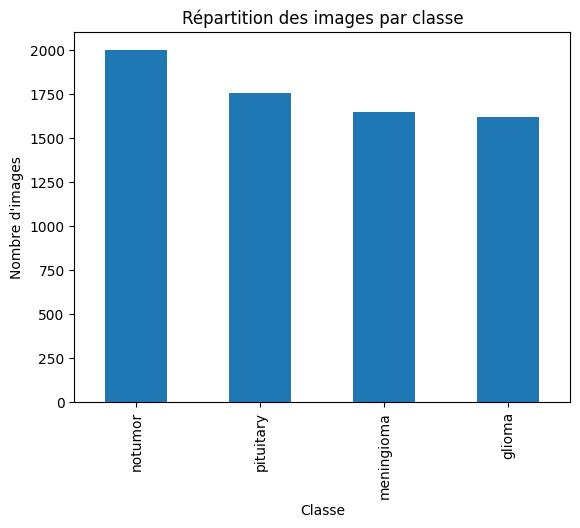

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'label': labels_np})
df['label'].value_counts().plot(kind='bar')
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe")
plt.show()

### Aperçu d’images pour chaque classe

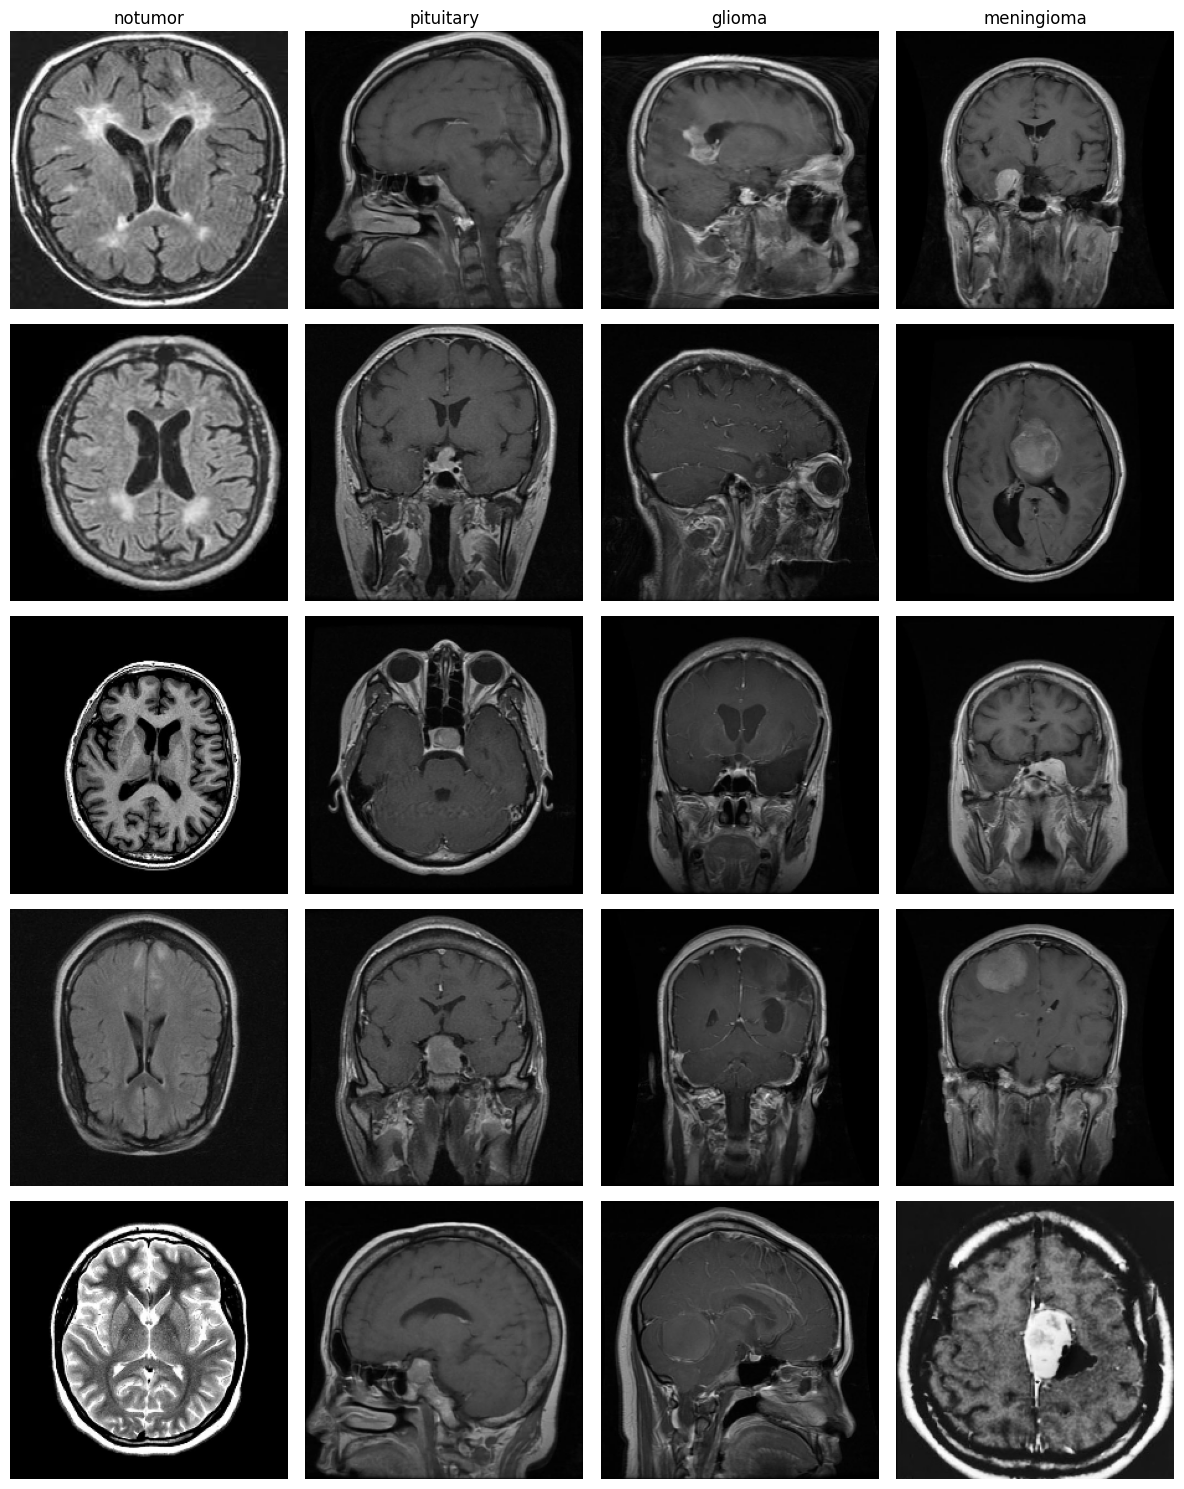

In [24]:
classes = list(set(labels_np))
fig, axes = plt.subplots(5, len(classes), figsize=(3*len(classes), 15))

for i, class_name in enumerate(classes):
    class_images = [img for img, label in zip(images_np, labels_np) if label == class_name]
    
    for j in range(5):
        if j < len(class_images):
            axes[j, i].imshow(class_images[j])
            if j == 0:
                axes[j, i].set_title(class_name)
            axes[j, i].axis('off')
plt.tight_layout()
plt.show()

### Vérifier l’équilibre entre les classes

In [25]:
from collections import Counter

class_counts = Counter(labels_np)

print("Nombre d'images par classe :")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Nombre d'images par classe :
glioma: 1621
meningioma: 1645
notumor: 2000
pituitary: 1757


### Application de rééquilibrage

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

for class_name in ['glioma', 'meningioma', 'pituitary']:
    class_imgs = [images_shuffled[i] for i, label in enumerate(labels_shuffled) if label == class_name]
    needed = 2000 - len(class_imgs)
    
    for i in range(needed):
        img = class_imgs[i % len(class_imgs)]
        aug_img = datagen.random_transform(img)
        images_shuffled.append(aug_img.astype('uint8'))
        labels_shuffled.append(class_name)

combined = list(zip(images_shuffled, labels_shuffled))
random.shuffle(combined)
images_shuffled, labels_shuffled = zip(*combined)
images_shuffled = list(images_shuffled)
labels_shuffled = list(labels_shuffled)

images_np = np.array(images_shuffled)
labels_np = np.array(labels_shuffled)


print("\nFinal counts:")
print(Counter(labels_shuffled))


Final counts:
Counter({'meningioma': 2000, 'pituitary': 2000, 'glioma': 2000, 'notumor': 2000})


### Transformation les étiquettes textuelles en format numérique

In [27]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()

integer_labels = encoder.fit_transform(labels_np)

one_hot_labels = to_categorical(integer_labels)


### Division des données en ensembles d’entraînement et de test

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_np, one_hot_labels, test_size=0.2, random_state=42)

type(y_test)

numpy.ndarray

### Normalisation des valeurs des pixels dans la plage [0, 1]

In [29]:
X_train = X_train/255.0
X_test = X_test/255.0

### Définition de l’architecture CNN

In [30]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout 

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=3, activation ='relu', input_shape=(224,224,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation ='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(filters=128, kernel_size=3, activation ='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

c:\Users\moham\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Vérification de l’architecture du modèle

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,635,524 (21.50 MB)

 Trainable params: 5,635,524 (21.50 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])